## Import necessary packages

In [1]:
import numpy as np
import tensorflow as tf
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 25 # training cycles
INIT_LR = 1e-3 # learning rate
BS = 32 # batch size
default_image_size = tuple((256, 256)) # default image size
image_size = 0 # image size
directory_root = './input/plantvillage' # root directory of the data
width=256 # with 
height=256 # height
depth=3 # depth

Function to convert images to array

In [3]:
def convert_image_to_array(image_dir: any) -> any:
    """
    Convert the images to an array 
    supply the directory of the image

    Args:
        image_dir (_type_): _description_

    Returns:
        _type_: _description_
    """
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Soybean___healthy ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Spider_mites Two-spotted_spider_mite ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Tomato___Tomato_mosaic_virus .

Get Size of Processed Image

In [5]:
image_size = len(image_list)
image_size

4152

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
label_binarizer.classes_


array(['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
       'Corn_(maize)___Common_rust_',
       'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy',
       'Orange___Haunglongbing_(Citrus_greening)',
       'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
       'Potato___Early_blight', 'Potato___Late_blight',
       'Potato___healthy', 'Soybean___healthy', 'Tomato___Bacterial_spot',
       'Tomato___Early_blight', 'Tomato___Late_blight',
       'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
       'Tomato___Spider_mites Two-spotted_spider_mite',
       'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
       'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'], dtype='<U50')

In [7]:
# normalize the images
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [8]:
# split the data into training and testing set
print("[INFO] Spliting data to train, test")
x_main, x_test, y_main, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [9]:
# main size
len(x_main)

3321

In [10]:
# test size
len(x_test)

831

In [11]:
# split the train into training and validation sets
print("[INFO] Spliting data to train, validation")
x_train, x_val, y_train, y_val = train_test_split(
    x_main, 
    y_main,
    test_size=0.2, 
    random_state=42
)

[INFO] Spliting data to train, validation


In [12]:
# train size
len(x_train)

2656

In [13]:
# validation size
len(x_val)


665

In [14]:
aug = ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode="nearest"
)

In [15]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation(tf.nn.relu))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation(tf.nn.relu))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation(tf.nn.relu))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation(tf.nn.relu))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation(tf.nn.relu))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation(tf.nn.relu))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation(tf.nn.softmax))

Model Summary

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [17]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(
    loss="binary_crossentropy", 
    optimizer=opt,
    metrics=[
        tf.keras.metrics.Accuracy(),
    ]
)
# train the network
print("[INFO] training network...")

[INFO] training network...


In [18]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
83/83 [==============================] - 296s 3s/step - loss: 0.1405 - accuracy: 0.0000e+00 - categorical_accuracy: 0.4273 - val_loss: 0.5159 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.0451
Epoch 2/25
83/83 [==============================] - 264s 3s/step - loss: 0.1077 - accuracy: 7.1715e-05 - categorical_accuracy: 0.5520 - val_loss: 0.8268 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.0451
Epoch 3/25
83/83 [==============================] - 259s 3s/step - loss: 0.0868 - accuracy: 1.7929e-05 - categorical_accuracy: 0.6359 - val_loss: 0.7708 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.0406
Epoch 4/25
83/83 [==============================] - 252s 3s/step - loss: 0.0911 - accuracy: 1.7929e-04 - categorical_accuracy: 0.6348 - val_loss: 0.7268 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.0812
Epoch 5/25
83/83 [==============================] - 313s 4s/step - loss: 0.0878 - accuracy: 3.4065e-04 - categorical_accuracy: 0.6352 - val_

Plot the train and val curve

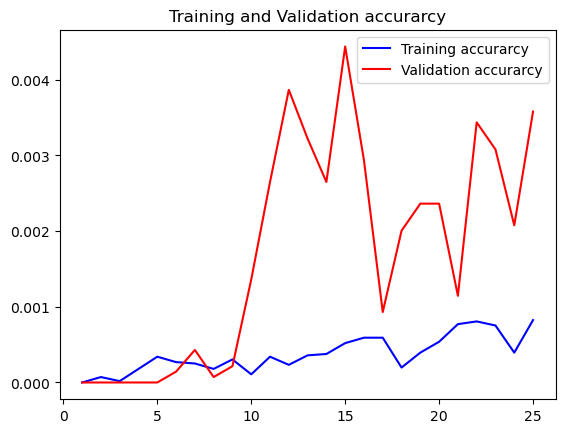

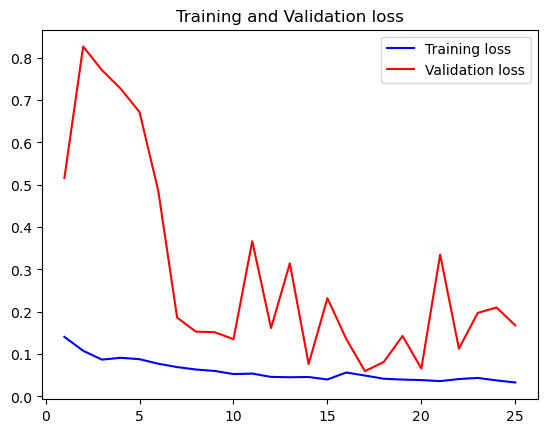

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [21]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
26/26 [==============================] - 27s 975ms/step - loss: 0.1651 - accuracy: 0.0032 - categorical_accuracy: 0.6294
Test Accuracy: 0.3151681739836931


Save model using Pickle

In [ ]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))